# Intro to IRT

In this notebook, we will give you an intro to IRT.
We will cover:

* The data format py-irt uses
* Using off the shelf models from py-irt
* Implementing your own model

In [1]:
import sys
import numpy as np
from pydantic import BaseModel

# Add py-irt if using git cloned version
# sys.path.append("/data/home/par/code/py-irt")

# Assumptions

* Subjects
    * Subjects will have a randomly drawn skill
    * 10 Subjects
* Items
    * Each item has a difficulty that we will randomly draw
    * Each item will be valid at `validity_rate` rate, and invalid otherwise
    * 1,000 Items
* Responses (correctness of subject responses to items)
    * If the item is valid: Determine randomly according to IRT equation
    * If invalid: flip a fair coin


In [2]:
class Item(BaseModel):
    valid: bool
    difficulty: float
    item_id: str
    category: str = 'all'

class Subject(BaseModel):
    subject_id: str
    skill: float

min_diff = -4
max_diff = 4
validity_rate = .9
def create_item(item_id: str, category: str):
    validity = np.random.uniform()
    if validity > validity_rate:
        valid = 0
    else:
        valid = 1
    return Item(item_id=item_id, valid=valid, difficulty=np.random.uniform(low=min_diff, high=max_diff), category=category)


max_skill = 4
min_skill = -4

def create_subject(subject_id: str):
    return Subject(subject_id=subject_id, skill=np.random.uniform(low=min_skill, high=max_skill))

In [3]:
items = [create_item(f'item_{idx}', 'all') for idx in range(1_000)]
subjects = [create_subject(f'subject_{idx}') for idx in range(10)]

# Exporting to py-irt Jsonlines format

So that we can use the built-in py-irt data loader, we will write this dataset to jsonlines.
The format is:
- Valid Line: `"subject_id": "<subject_id>", "responses": {"<item_id>": <response>}}`
- Responses are 1 or 0.
- Note, responses is a dictionary and it does not need to be complete.

In [4]:

# We'll do a quick export to json to make reading the dataset easier. From the docs:
# Each row looks like this:
# {"subject_id": "<subject_id>", "responses": {"<item_id>": <response>}}
import random
from py_irt.io import write_jsonlines
from py_irt.dataset import Dataset

def write_irt_dataset(subjects: list[Subject], items: list[Item], path: str):
    print("Writing dataset with")
    print("N Subjects", len(subjects))
    print("N Items", len(items))
    rows = []
    score_by_subject = {}
    lookup = {}
    for subject in subjects:
        responses = {}
        correct = 0
        total = 0
        for item in items:
            if item.valid:
                responses[item.item_id] = int(1 / (1 + np.exp(-(subject.skill - item.difficulty))) > random.random())
            else:
                responses[item.item_id] = int(random.random() > .5)
            correct += responses[item.item_id]
            total += 1
        score_by_subject[subject.subject_id] = correct / total
        lookup[subject.subject_id] = responses
        rows.append({"subject_id": subject.subject_id, "responses": responses})

    write_jsonlines(path, rows)
    return score_by_subject, lookup
score_by_subject, subject_responses = write_irt_dataset(subjects, items, '/tmp/irt_dataset_section_2.jsonlines')

Writing dataset with
N Subjects 10
N Items 1000


# Reading data in py-irt and Training a model

Next, we will:

* Read this dataset in py-irt
* Create a basic config
* Train a simple 1PL model

Afterwards, we will:
* Dig into the py-irt model definition and adapt it to work for 2PL

In [5]:
from py_irt.dataset import Dataset

dataset = Dataset.from_jsonlines("/tmp/irt_dataset_section_2.jsonlines")

[18:04:58] amortized: False                                                                          ]8;id=224036;file:///data/home/par/code/py-irt/py_irt/dataset.py\dataset.py]8;;\:]8;id=692506;file:///data/home/par/code/py-irt/py_irt/dataset.py#112\112]8;;\

In [5]:
from py_irt.config import IrtConfig
from py_irt.training import IrtModelTrainer

config = IrtConfig(model_type='1pl', log_every=500, dropout=.2)
trainer = IrtModelTrainer(config=config, data_path=None, dataset=dataset)
trainer.train(epochs=5000, device='cuda')

[16:43:19] amortized: False                                                                          ]8;id=800598;file:///data/home/par/code/py-irt/py_irt/dataset.py\dataset.py]8;;\:]8;id=493125;file:///data/home/par/code/py-irt/py_irt/dataset.py#112\112]8;;\

[16:43:19] Vocab size: None                                                                          ]8;id=668016;file:///data/home/par/code/py-irt/py_irt/training.py\training.py]8;;\:]8;id=550119;file:///data/home/par/code/py-irt/py_irt/training.py#90\90]8;;\

           args: {'device': 'cuda', 'num_items': 1000, 'num_subjects': 10}                          ]8;id=265960;file:///data/home/par/code/py-irt/py_irt/training.py\training.py]8;;\:]8;id=725383;file:///data/home/par/code/py-irt/py_irt/training.py#134\134]8;;\

           Parsed Model Args: {'device': 'cuda', 'num_items': 1000, 'num_subjects': 10, 'priors':   ]8;id=124243;file:///data/home/par/code/py-irt/py_irt/training.py\training.py]8;;\:]8;id=756558;file:///data/home/par/code/py-irt/py_irt/training.py#147\147]8;;\
           'vague', 'dropout': 0.2, 'hidden': 100, 'vocab_size': None}                                             

Output()

Training Pyro IRT Model for 5000 epochs

torch.Size([10000]) torch.Size([10000])


In [6]:
# Next we can compare: Actual skill, inferred skill, and accuracy
for subject, skill, acc in sorted(list(zip(subjects, trainer.last_params['ability'], score_by_subject.values())), key=lambda v: v[0].skill):
    print(subject.subject_id, "Real Skill", subject.skill, "Inferred Skill", skill, "Acc", acc)

subject_8 Real Skill -3.884467092477161 Inferred Skill -3.346115827560425 Acc 0.127
subject_3 Real Skill -2.4092903253582962 Inferred Skill -2.1541693210601807 Acc 0.226
subject_2 Real Skill -2.1774244939456846 Inferred Skill -1.9487590789794922 Acc 0.26
subject_5 Real Skill -2.1411686953088873 Inferred Skill -1.7273616790771484 Acc 0.288
subject_0 Real Skill -1.2458803146590771 Inferred Skill -0.6864756345748901 Acc 0.387
subject_9 Real Skill 0.08445832670945386 Inferred Skill 0.10757223516702652 Acc 0.506
subject_4 Real Skill 0.6030642924177165 Inferred Skill 0.5390836000442505 Acc 0.556
subject_1 Real Skill 2.0165246707222027 Inferred Skill 1.9551409482955933 Acc 0.708
subject_6 Real Skill 3.2611789714609936 Inferred Skill 3.055710554122925 Acc 0.816
subject_7 Real Skill 3.3842764622290247 Inferred Skill 3.1915154457092285 Acc 0.822


In [7]:
for item, diff in sorted(list(zip(items, trainer.last_params["diff"]))[:20], key=lambda v: v[0].difficulty):
    print(item.difficulty, diff)

-3.990418584245244 -3.9722235202789307
-2.6011726771435217 -0.31765908002853394
-2.0620805079999878 -1.6781026124954224
-2.0136971311869223 -3.920189380645752
-1.3044214045970879 -0.9731835126876831
-1.2403805966596124 -1.7017406225204468
-0.4605605330027691 -0.06663890182971954
-0.22063079854633472 -0.09359151124954224
0.1587640996540305 0.40942835807800293
0.5606946449544852 0.2367488145828247
1.0069018644358296 -1.8538750410079956
1.1559239117148525 -1.6636019945144653
1.1776646088154727 1.5613257884979248
1.6586750877950083 2.6625564098358154
2.2038272056877064 1.1499176025390625
2.265316853736441 -0.1889083981513977
2.872176916289317 3.8063602447509766
3.86651072108923 3.609407663345337
3.895528635928546 2.5975146293640137
3.9071289046765534 32.72386169433594


# Defining and modifying our own model

In the previous example, we used a off-the-shelf model, but it is not too difficult to modify an existing model. In general, model definitions will have:
- A model: This represents our generative story, i.e P(Z|X)
- A guide: This represents the approximating distribution, Q(Z)
- Helper functions (e.g., fit, export, etc)

If we look at the non-commented code, we will see:
1. `observe_data`: represents the IRT equation
2. There are two levels of sampling statements:
    1. The draw of IRT parameters from a distribution
    2. The draw of parameters of that distribution

So to add a new variable, for example discriminability, we will need to:
1. In the model, add sampling statements for the priors
2. In the model, add sampling statement for discrimability
3. Incorporate the variable in the `observe_data` statement
4. In the guide, make parallel changes.

As for what distribution to use, we'll make a slight change and keep discriminability non-negative by instead of drawing `disc~Normal`, we'll have `log disc ~ Normal` which is equivalent to `disc ~ LogNormal`.

In [10]:
# Copied from tutorial_section_2_start.py
from py_irt.models import abstract_model
import pyro
import pyro.distributions as dist
import torch

import torch.distributions.constraints as constraints

from pyro.infer import SVI, Trace_ELBO, EmpiricalMarginal
from pyro.optim import Adam

import pandas as pd

from functools import partial

import numpy as np


class TutorialSection2Model(abstract_model.IrtModel):
    """1PL IRT model"""

    def __init__(
        self,
        *,
        priors: str,
        num_items: int,
        num_subjects: int,
        verbose: bool = False,
        device: str = "cpu",
        vocab_size: int = None,
        dropout: float = None,
        hidden: int = None,
        **kwargs,
    ):
        super().__init__(
            device=device,
            num_items=num_items,
            num_subjects=num_subjects,
            verbose=verbose,
        )

    def model_hierarchical(self, models, items, obs):
        mu_b = pyro.sample(
            "mu_b",
            dist.Normal(
                torch.tensor(0.0, device=self.device),
                torch.tensor(1.0e6, device=self.device),
            ),
        )
        u_b = pyro.sample(
            "u_b",
            dist.Gamma(
                torch.tensor(1.0, device=self.device),
                torch.tensor(1.0, device=self.device),
            ),
        )
        mu_theta = pyro.sample(
            "mu_theta",
            dist.Normal(
                torch.tensor(0.0, device=self.device),
                torch.tensor(1.0e6, device=self.device),
            ),
        )
        u_theta = pyro.sample(
            "u_theta",
            dist.Gamma(
                torch.tensor(1.0, device=self.device),
                torch.tensor(1.0, device=self.device),
            ),
        )
######################################################################
        # START: NEW CODE
        mu_gamma = pyro.sample(
            "mu_gamma",
            dist.Normal(
                torch.tensor(0.0, device=self.device),
                torch.tensor(1.0e6, device=self.device)
            )
        )
        u_gamma = pyro.sample(
            "u_gamma",
            dist.Gamma(
                torch.tensor(1.0, device=self.device),
                torch.tensor(1.0, device=self.device),
            )
        )
        with pyro.plate("gammas", self.num_items, device=self.device):
            disc = pyro.sample("gamma", dist.LogNormal(mu_gamma, 1 / u_gamma))
        # END: NEW CODE
######################################################################
        with pyro.plate("thetas", self.num_subjects, device=self.device):
            ability = pyro.sample("theta", dist.Normal(mu_theta, 1.0 / u_theta))
        with pyro.plate("bs", self.num_items, device=self.device):
            diff = pyro.sample("b", dist.Normal(mu_b, 1.0 / u_b))
        with pyro.plate("observe_data", obs.size(0)):
            pyro.sample(
                "obs",

################# New Sampling statement ##################
                dist.Bernoulli(logits=disc[items] * (ability[models] - diff[items])), obs=obs
################## Original statement ####################
                #dist.Bernoulli(logits=ability[models] - diff[items]), obs=obs
            )

    def guide_hierarchical(self, models, items, obs):
        loc_mu_b_param = pyro.param("loc_mu_b", torch.tensor(0.0, device=self.device))
        scale_mu_b_param = pyro.param(
            "scale_mu_b",
            torch.tensor(1.0e2, device=self.device),
            constraint=constraints.positive,
        )
        loc_mu_theta_param = pyro.param(
            "loc_mu_theta", torch.tensor(0.0, device=self.device)
        )
        scale_mu_theta_param = pyro.param(
            "scale_mu_theta",
            torch.tensor(1.0e2, device=self.device),
            constraint=constraints.positive,
        )
        alpha_b_param = pyro.param(
            "alpha_b",
            torch.tensor(1.0, device=self.device),
            constraint=constraints.positive,
        )
        beta_b_param = pyro.param(
            "beta_b",
            torch.tensor(1.0, device=self.device),
            constraint=constraints.positive,
        )
        alpha_theta_param = pyro.param(
            "alpha_theta",
            torch.tensor(1.0, device=self.device),
            constraint=constraints.positive,
        )
        beta_theta_param = pyro.param(
            "beta_theta",
            torch.tensor(1.0, device=self.device),
            constraint=constraints.positive,
        )
        m_theta_param = pyro.param(
            "loc_ability", torch.zeros(self.num_subjects, device=self.device)
        )
        s_theta_param = pyro.param(
            "scale_ability",
            torch.ones(self.num_subjects, device=self.device),
            constraint=constraints.positive,
        )
        m_b_param = pyro.param(
            "loc_diff", torch.zeros(self.num_items, device=self.device)
        )
        s_b_param = pyro.param(
            "scale_diff",
            torch.ones(self.num_items, device=self.device),
            constraint=constraints.positive,
        )

######### New parameters for disc ################
        loc_mu_gamma_param = pyro.param(
            "loc_mu_gamma", torch.tensor(0.0, device=self.device)
        )
        scale_mu_gamma_param = pyro.param(
            "scale_mu_gamma",
            torch.tensor(1.0e2, device=self.device),
            constraint=constraints.positive,
        )
        alpha_gamma_param = pyro.param(
            "alpha_gamma",
            torch.tensor(1.0, device=self.device),
            constraint=constraints.positive,
        )
        beta_gamma_param = pyro.param(
            "beta_gamma",
            torch.tensor(1.0, device=self.device),
            constraint=constraints.positive,
        )
        m_gamma_param = pyro.param("loc_disc", torch.zeros(self.num_items, device=self.device))
        s_gamma_param = pyro.param("scale_disc", torch.ones(self.num_items, device=self.device), constraint=constraints.positive)


        # sample statements
        pyro.sample("mu_b", dist.Normal(loc_mu_b_param, scale_mu_b_param))
        pyro.sample("u_b", dist.Gamma(alpha_b_param, beta_b_param))
        pyro.sample("mu_theta", dist.Normal(loc_mu_theta_param, scale_mu_theta_param))
        pyro.sample("u_theta", dist.Gamma(alpha_theta_param, beta_theta_param))
        # New Sampling
        # Prior sampling
        pyro.sample("mu_gamma", dist.Normal(loc_mu_gamma_param, scale_mu_gamma_param))
        pyro.sample("u_gamma", dist.Gamma(alpha_gamma_param, beta_gamma_param))
        # Paramter sampling
        with pyro.plate("gammas", self.num_items, device=self.device):
            pyro.sample("gamma", dist.LogNormal(m_gamma_param, s_gamma_param))

        with pyro.plate("thetas", self.num_subjects, device=self.device):
            pyro.sample("theta", dist.Normal(m_theta_param, s_theta_param))
        with pyro.plate("bs", self.num_items, device=self.device):
            pyro.sample("b", dist.Normal(m_b_param, s_b_param))

    def get_model(self):
        return self.model_hierarchical

    def get_guide(self):
        return self.guide_hierarchical

    def fit(self, models, items, responses, num_epochs):
        """Fit the IRT model with variational inference"""
        optim = Adam({"lr": 0.1})
        svi = SVI(
            self.model_hierarchical,
            self.guide_hierarchical,
            optim,
            loss=Trace_ELBO(),
        )

        pyro.clear_param_store()
        for j in range(num_epochs):
            loss = svi.step(models, items, responses)
            if j % 100 == 0 and self.verbose:
                print("[epoch %04d] loss: %.4f" % (j + 1, loss))

        print("[epoch %04d] loss: %.4f" % (j + 1, loss))
        values = ["loc_diff", "scale_diff", "loc_ability", "scale_ability"]

    def export(self):
        return {
            "ability": pyro.param("loc_ability").data.tolist(),
            "diff": pyro.param("loc_diff").data.tolist(),
            "disc": pyro.param("loc_disc").data.tolist(),
        }

    def predict(self, subjects, items, params_from_file=None):
        """predict p(correct | params) for a specified list of model, item pairs"""
        if params_from_file is not None:
            model_params = params_from_file
        else:
            model_params = self.export()
        abilities = np.array([model_params["ability"][i] for i in subjects])
        diffs = np.array([model_params["diff"][i] for i in items])
        discs = np.array([model_params["disc"][i] for i in items])
        return 1 / (1 + np.exp(-discs * (abilities - diffs)))

    def summary(self, traces, sites):
        """Aggregate marginals for MCM"""
        marginal = (
            EmpiricalMarginal(traces, sites)
            ._get_samples_and_weights()[0]
            .detach()
            .cpu()
            .numpy()
        )
        print(marginal)
        site_stats = {}
        for i in range(marginal.shape[1]):
            site_name = sites[i]
            marginal_site = pd.DataFrame(marginal[:, i]).transpose()
            describe = partial(
                pd.Series.describe, percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]
            )
            site_stats[site_name] = marginal_site.apply(describe, axis=1)[
                ["mean", "std", "5%", "25%", "50%", "75%", "95%"]
            ]
        return site_stats


In [12]:
from py_irt.config import IrtConfig
from py_irt.training import IrtModelTrainer

config = IrtConfig(model_type=TutorialSection2Model, log_every=500, dropout=.2)
trainer = IrtModelTrainer(config=config, data_path=None, dataset=dataset)
trainer.train(epochs=2000, device='cuda')

[18:15:45] Vocab size: None                                                                          ]8;id=195461;file:///data/home/par/code/py-irt/py_irt/training.py\training.py]8;;\:]8;id=742881;file:///data/home/par/code/py-irt/py_irt/training.py#93\93]8;;\

           args: {'device': 'cuda', 'num_items': 1000, 'num_subjects': 10}                          ]8;id=708118;file:///data/home/par/code/py-irt/py_irt/training.py\training.py]8;;\:]8;id=605413;file:///data/home/par/code/py-irt/py_irt/training.py#143\143]8;;\

           Parsed Model Args: {'device': 'cuda', 'num_items': 1000, 'num_subjects': 10, 'priors':   ]8;id=653844;file:///data/home/par/code/py-irt/py_irt/training.py\training.py]8;;\:]8;id=159817;file:///data/home/par/code/py-irt/py_irt/training.py#156\156]8;;\
           'vague', 'dropout': 0.2, 'hidden': 100, 'vocab_size': None}                                             

Output()

Training Pyro IRT Model for 2000 epochs

torch.Size([10000]) torch.Size([10000])


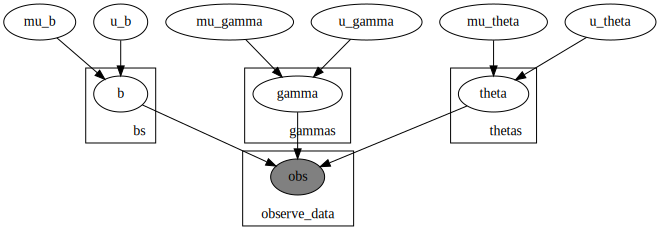

In [23]:
import pyro

pyro.render_model(trainer._pyro_model, model_args=(
    torch.zeros(1000, dtype=torch.long, device='cuda'),
    torch.zeros(1000, dtype=torch.long, device='cuda'),
    torch.zeros(1000, dtype=torch.float, device='cuda'),
))

In [13]:
# Next we can compare: Actual skill, inferred skill, and accuracy
for subject, skill, acc in sorted(list(zip(subjects, trainer.last_params['ability'], score_by_subject.values())), key=lambda v: v[0].skill):
    print(subject.subject_id, "Real Skill", subject.skill, "Inferred Skill", skill, "Acc", acc)

subject_8 Real Skill -2.0992039470170196 Inferred Skill -4.6167683601379395 Acc 0.299
subject_0 Real Skill -1.1475070994498333 Inferred Skill -0.4494936466217041 Acc 0.381
subject_9 Real Skill -0.820635677327914 Inferred Skill 0.22900916635990143 Acc 0.417
subject_3 Real Skill 0.1286691849779622 Inferred Skill 1.454652190208435 Acc 0.517
subject_5 Real Skill 0.4896205821266699 Inferred Skill 1.7657090425491333 Acc 0.543
subject_2 Real Skill 0.6767643123720228 Inferred Skill 1.977298617362976 Acc 0.582
subject_6 Real Skill 0.7634125176672466 Inferred Skill 1.9012914896011353 Acc 0.573
subject_4 Real Skill 1.768818348571382 Inferred Skill 4.846320629119873 Acc 0.675
subject_1 Real Skill 2.925906218662666 Inferred Skill 7.383442401885986 Acc 0.79
subject_7 Real Skill 3.6667097508179456 Inferred Skill 12.50934886932373 Acc 0.86


In [15]:
for item, diff, disc in sorted(list(zip(items, trainer.last_params["diff"], trainer.last_params['disc']))[:20], key=lambda v: v[0].difficulty):
    print(item.difficulty, diff, disc)

-3.8217550888270777 -3.5826640129089355 2.1924033164978027
-3.69833877591533 -9.665823936462402 0.6793660521507263
-3.4538712920910974 -9.909111022949219 -0.14002259075641632
-3.4031693619313703 -9.54269027709961 0.08277589827775955
-3.3821151826150695 -3.430758476257324 -1.6421877145767212
-3.3417983185345825 -10.073620796203613 0.8655638694763184
-3.2896540965974825 -9.245588302612305 1.2930814027786255
-3.1218402625983757 -4.012744426727295 0.9936566948890686
-2.0961132414719534 -6.080544948577881 -1.4029154777526855
-0.5853620860445243 0.8478484749794006 0.3265891969203949
0.1524570163147061 1.7222025394439697 -0.3942753076553345
0.36958442550909076 0.6623020768165588 0.25205308198928833
0.5101799299201764 4.00017786026001 -2.9407012462615967
0.9451040264956427 8.412286758422852 -2.2563652992248535
1.1586789766540804 1.7541354894638062 -0.1581266075372696
1.7491729978605326 7.629848957061768 -1.6286585330963135
1.8610770213746637 7.323568820953369 -0.9194203019142151
1.911772588895